In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

data = pd.read_csv('Training_high/Line3_6_high.csv')
data_int=data.iloc[:,:]

data_int_10=np.tile(data_int, (30, 1)) #串聯10倍長度
mean,var = 0,0.001
noise = np.random.normal(mean, var, data_int_10.shape[0]) #並加入noise
noise = np.random.normal(mean, var, data_int_10.shape) #並加入noise
print(noise.shape)
data_noise_10 = data_int_10+noise*0.00001 #嘗試在不同大小的noise

X = data_noise_10[:, :2]
y = data_noise_10[:, 2:7]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)



(76230, 9)
(60984, 2) (15246, 2) (60984, 5) (15246, 5)


In [2]:
xgb = XGBRegressor(objective='reg:squarederror',
                   seed=42)
param_grid = {
    'estimator__learning_rate': [0.01,0.05,0.1,0.2],
    'estimator__n_estimators': [800,900,1000],
    'estimator__max_depth': [7,8,9,10,11,12],
      'estimator__min_child_weight': [5 , 7],
      'estimator__gamma': [0.0,0.1],
      'estimator__subsample': [0.8, 0.9 , 1]
}
# 
multi_output_model = MultiOutputRegressor(xgb)

grid_search = GridSearchCV(estimator=multi_output_model,
                           param_grid=param_grid,
                           cv=3,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1
                          )

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

best_xgb_model = XGBRegressor(objective='reg:squarederror',
                              learning_rate=best_params['estimator__learning_rate'],
                              n_estimators=best_params['estimator__n_estimators'],
                              max_depth=best_params['estimator__max_depth'],
                              min_child_weight=best_params['estimator__min_child_weight'],
                              gamma=best_params['estimator__gamma'],
                              subsample=best_params['estimator__subsample'],
                              colsample_bytree=0.8,
                              reg_alpha=0,
                              reg_lambda=1,
                              seed=42)
best_multi_output_model = MultiOutputRegressor(best_xgb_model)

best_multi_output_model.fit(X_train, y_train)

y_pred = best_multi_output_model.predict(X_test)
# 
r2_scores = r2_score(y_test, y_pred, multioutput='raw_values')
print(f'R² scores for each output: {r2_scores}')

Fitting 3 folds for each of 864 candidates, totalling 2592 fits


C:\Users\adm\anaconda3\envs\myenv36\lib\site-packages\xgboost\data.py:107: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


Best parameters found: {'estimator__gamma': 0.0, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 9, 'estimator__min_child_weight': 5, 'estimator__n_estimators': 1000, 'estimator__subsample': 0.8}


C:\Users\adm\anaconda3\envs\myenv36\lib\site-packages\xgboost\data.py:107: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


R² scores for each output: [0.28771487 0.83107949 0.99932501 0.99856594 0.99986251]


In [3]:
RMSE=np.sqrt(sum((y_test-y_pred) ** 2)/(y_pred.size))
print('RMSE [S11,S21,beta,alpha,Zo] : ')#,S11(angle),S21(angle)
print(RMSE)
NRMSE=RMSE/abs(np.mean(y_pred, axis=0))
print('NRMSE [S11,S21,beta,alpha,Zo] :')# ,S11(angle),S21(angle)
print(NRMSE)

RMSE [S11,S21,beta,alpha,Zo] : 
[1.54487857 0.20909087 1.31121354 0.00419498 0.23463523]
NRMSE [S11,S21,beta,alpha,Zo] :
[0.09807012 0.05361756 0.00058024 0.0008232  0.00196418]


In [4]:
best_xgb_model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=best_params['estimator__learning_rate'],
    n_estimators=best_params['estimator__n_estimators'],
    max_depth=best_params['estimator__max_depth'],
    min_child_weight=best_params['estimator__min_child_weight'],
    gamma=best_params['estimator__gamma'],
    subsample=best_params['estimator__subsample'],
    seed=42
)
head=401*0 #後面乘上的數字等於第幾組數據 數據in平板 因為81個頻率點
data = pd.read_csv('only_freq_high.csv')##val_input.csv
X_val = data.iloc[:,:]
# 
best_multi_output_model = MultiOutputRegressor(best_xgb_model)

best_multi_output_model.fit(X_train, y_train)

y_pred_val = best_multi_output_model.predict(X_val)

y_pred_val_df = pd.DataFrame(y_pred_val,columns=['s11','s21','beta','alpha','Zo'])
y_pred_val_df.to_csv('validation/y_pred_3_6_high.csv', index=False)

C:\Users\adm\anaconda3\envs\myenv36\lib\site-packages\xgboost\data.py:107: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


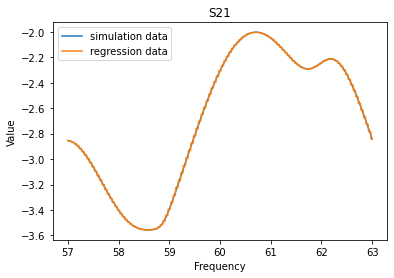

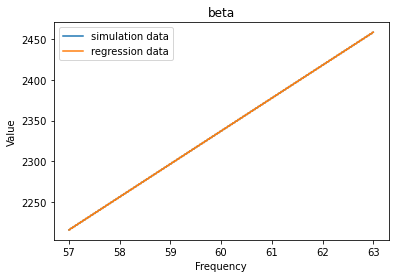

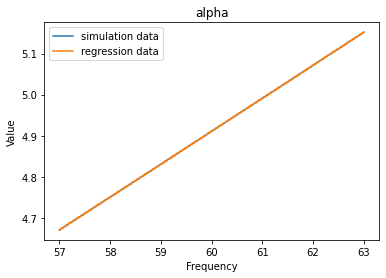

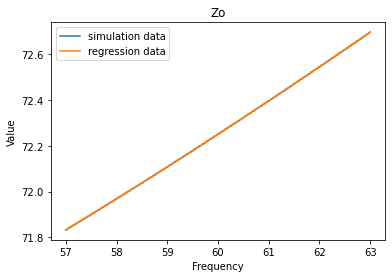

In [6]:
import matplotlib.pyplot as plt

k = 19
head_121=k*121
head_601=k*601

data_int = np.array(data_int)
freq_121=np.arange(57, 63.05, 0.05)
freq_601=np.arange(57, 63.01, 0.01)
plt.plot(freq_121, data_int[head_121:head_121+121, 3], label='simulation data')
plt.plot(freq_601, y_pred_val[head_601:head_601+601, 1], label='regression data')
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.title('S21')
plt.legend()
plt.show()

#beta
plt.plot(freq_121, data_int[head_121:head_121+121, 4], label='simulation data')
plt.plot(freq_601, y_pred_val[head_601:head_601+601, 2], label='regression data')
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.title('beta')
plt.legend()
plt.show()

#alpha
plt.plot(freq_121, data_int[head_121:head_121+121, 5], label='simulation data')
plt.plot(freq_601, y_pred_val[head_601:head_601+601, 3], label='regression data')
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.title('alpha')
plt.legend()
plt.show()

#Zo
plt.plot(freq_121, data_int[head_121:head_121+121, 6], label='simulation data')
plt.plot(freq_601, y_pred_val[head_601:head_601+601, 4], label='regression data')
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.title('Zo')
plt.legend()
plt.show()